<a href="https://colab.research.google.com/github/shantanu812/MLProjects/blob/main/SketchRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sketch Recognition using RNNs and CNNs

##Downloading Dataset

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt


In [5]:
download_root="http://download.tensorflow.org/data/"
filename="quickdraw_tutorial_dataset_v1.tar.gz"
filepath=tf.keras.utils.get_file(fname=filename,origin=download_root+filename,cache_dir=".",extract=True)

1065301781/1065301781 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [6]:
from pathlib import Path

In [7]:
if "_extracted" in filepath:
    quickdraw_dir = Path(filepath)
else:
    quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [8]:
print(train_files)
print(eval_files)

['datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00000-of-00010', 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00001-of-00010', 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00002-of-00010', 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00003-of-00010', 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00004-of-00010', 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00005-of-00010', 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00006-of-00010', 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00007-of-00010', 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00008-of-00010', 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00009-of-00010']
['datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00000-of-00010', 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-000

In [9]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [10]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [11]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

##Preprocessing Data

In [12]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [13]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [14]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [15]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.28235295 -0.23999998  0.        ]
  [-0.12156863 -0.2         0.        ]
  [ 0.03921569  0.23        0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.00574713  0.7254902   0.        ]
  [-0.02298851  0.19999999  0.        ]
  [ 0.07471264  0.01176471  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.05490196 -0.08040196  0.        ]
  [ 0.06666666 -0.14572865  0.        ]
  [ 0.08235294 -0.13065329  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.01282051  0.05882353  0.        ]
  [ 0.06410257  0.0509804   0.        ]
  [ 0.17948718  0.05098039  1.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

In [16]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches :", sketches)
    print("lengths :", lengths)
    print("labels :", labels)

sketches : tf.Tensor(
[[[-0.06666668 -0.21311477  0.        ]
  [-0.04705882 -0.20491804  0.        ]
  [-0.04313725 -0.1147541   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.02057618 -0.00392157  0.        ]
  [-0.22633743  0.09019608  0.        ]
  [-0.16872427  0.10196079  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.12549022 -0.03478259  0.        ]
  [-0.15686274 -0.00869566  0.        ]
  [-0.05490197  0.03043479  0.        ]
  ...
  [-0.03137255  0.05217391  0.        ]
  [-0.00784314  0.03043479  0.        ]
  [ 0.00392157 -0.02608693  1.        ]]

 ...

 [[ 0.05649716  0.34509805  0.        ]
  [ 0.0621469   0.18431371  0.        ]
  [-0.04519773  0.03529412  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

In [17]:
import numpy as np

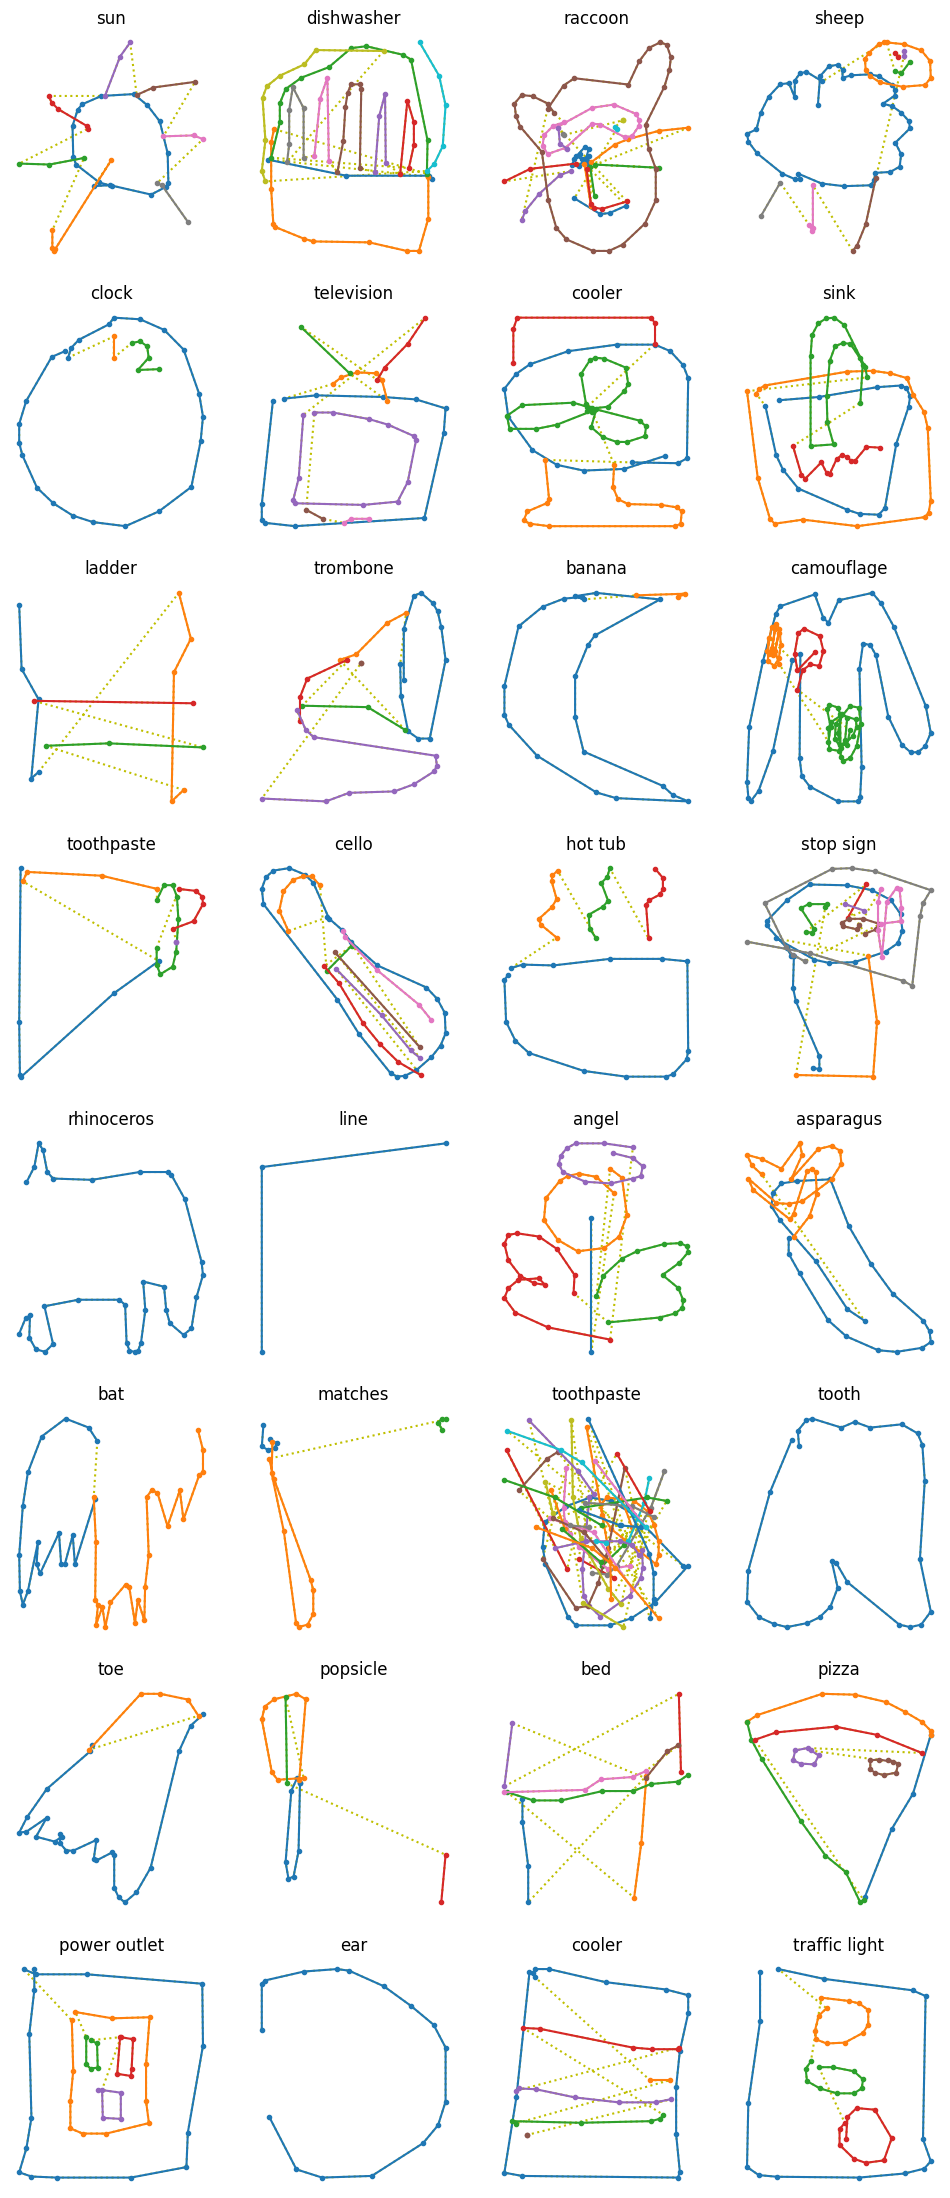

In [18]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

In [19]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])

In [20]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

##Model

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=3,
                    validation_data=cropped_valid_set)

Epoch 1/3
 107813/Unknown 1012s 9ms/step - accuracy: 0.0788 - loss: 4.8605 - sparse_top_k_categorical_accuracy: 0.2024

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


107813/107813 ━━━━━━━━━━━━━━━━━━━━ 1037s 10ms/step - accuracy: 0.0788 - loss: 4.8605 - sparse_top_k_categorical_accuracy: 0.2024 - val_accuracy: 0.3117 - val_loss: 3.0635 - val_sparse_top_k_categorical_accuracy: 0.5987
Epoch 2/3
107813/107813 ━━━━━━━━━━━━━━━━━━━━ 1042s 10ms/step - accuracy: 0.3517 - loss: 2.8569 - sparse_top_k_categorical_accuracy: 0.6396 - val_accuracy: 0.4374 - val_loss: 2.3972 - val_sparse_top_k_categorical_accuracy: 0.7252
Epoch 3/3
107813/107813 ━━━━━━━━━━━━━━━━━━━━ 1011s 9ms/step - accuracy: 0.4419 - loss: 2.3756 - sparse_top_k_categorical_accuracy: 0.7295 - val_accuracy: 0.4788 - val_loss: 2.1892 - val_sparse_top_k_categorical_accuracy: 0.7617


In [22]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step


In [23]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

np.float32(0.64170456)

##Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


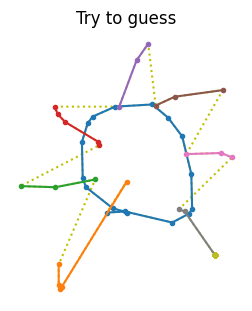

Top-5 predictions:
  1. sun 64.702%
  2. spider 22.562%
  3. crab 6.377%
  4. helicopter 1.300%
  5. flashlight 1.200%
Answer: sun


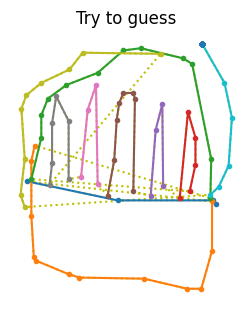

Top-5 predictions:
  1. couch 29.921%
  2. fireplace 28.322%
  3. castle 6.813%
  4. garden 5.469%
  5. bridge 4.770%
Answer: dishwasher


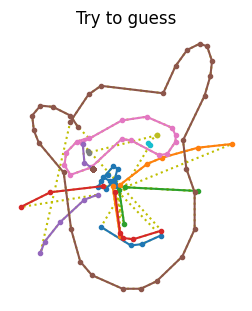

Top-5 predictions:
  1. cat 27.024%
  2. raccoon 11.215%
  3. tiger 8.907%
  4. crab 7.542%
  5. spider 7.533%
Answer: raccoon


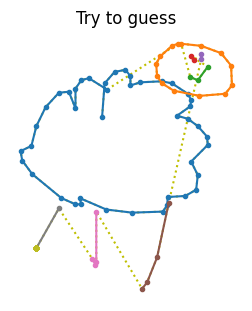

Top-5 predictions:
  1. rain 54.252%
  2. sheep 43.596%
  3. bush 0.218%
  4. broccoli 0.197%
  5. bear 0.194%
Answer: sheep


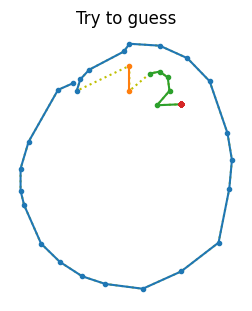

Top-5 predictions:
  1. blueberry 33.230%
  2. pear 16.334%
  3. potato 14.429%
  4. circle 9.427%
  5. necklace 2.314%
Answer: clock


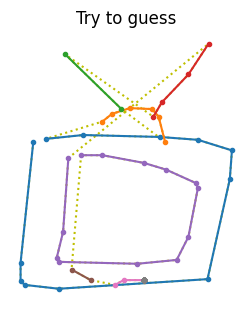

Top-5 predictions:
  1. television 83.126%
  2. radio 9.378%
  3. syringe 0.707%
  4. hospital 0.557%
  5. church 0.555%
Answer: television


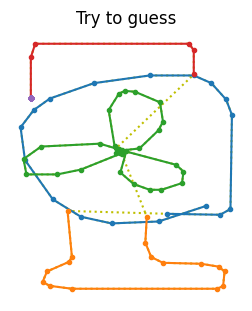

Top-5 predictions:
  1. fan 37.267%
  2. hot air balloon 11.584%
  3. skull 11.413%
  4. light bulb 8.392%
  5. hamburger 3.499%
Answer: cooler


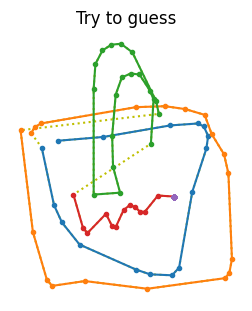

Top-5 predictions:
  1. sink 70.122%
  2. hot tub 3.683%
  3. purse 2.862%
  4. bathtub 1.709%
  5. submarine 1.683%
Answer: sink


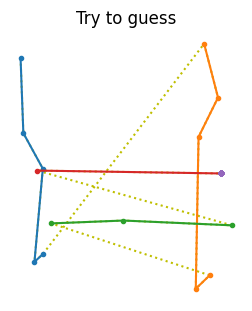

Top-5 predictions:
  1. ladder 81.587%
  2. skyscraper 5.246%
  3. triangle 1.405%
  4. bed 0.987%
  5. the eiffel tower 0.943%
Answer: ladder


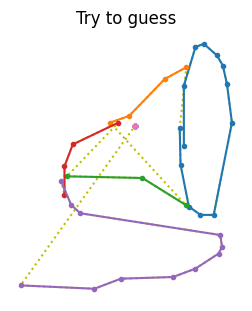

Top-5 predictions:
  1. helicopter 14.590%
  2. flying saucer 11.455%
  3. trombone 7.982%
  4. submarine 6.964%
  5. mosquito 5.044%
Answer: trombone


In [24]:

n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [25]:
model.save("my_sketchrnn.keras")